In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from oasis.functions import deconvolve
from scipy.stats import pearsonr

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

import utils.sulfur.constant as const

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

non_engram_shock_cells = {
    'ID181106CreA': ['C000', 'C007', 'C009', 'C059', 'C076', 'C084', 'C086', 'C099', 'C101', 'C116', 'C120', 'C124', 'C141', 'C143', 'C145', 'C153', 'C164', 'C173', 'C175', 'C197', 'C198', 'C228', 'C234', 'C235', 'C284', 'C303', 'C306', 'C310', 'C317', 'C325', 'C327', 'C328', 'C336', 'C362', 'C377', 'C442', 'C459', 'C476', 'C479', 'C480', 'C487', 'C491', 'C493', 'C494', 'C519'],
    'ID181106CreB': ['C000', 'C003', 'C009', 'C010', 'C063', 'C066', 'C071', 'C072', 'C073', 'C080', 'C083', 'C088', 'C090', 'C094', 'C100', 'C103', 'C108', 'C109', 'C112', 'C114', 'C115', 'C127', 'C130', 'C131', 'C134', 'C166', 'C168', 'C169', 'C177', 'C178', 'C179', 'C200', 'C202', 'C203', 'C213', 'C230', 'C231', 'C268', 'C279', 'C282', 'C284'],
    'ID181106CreC': ['C002', 'C011', 'C012', 'C016', 'C019', 'C043', 'C045', 'C049', 'C050', 'C054', 'C055', 'C056', 'C058', 'C060', 'C063', 'C070', 'C072', 'C074', 'C076', 'C079', 'C084', 'C086', 'C088', 'C096', 'C105', 'C107', 'C118', 'C127', 'C132', 'C143', 'C144', 'C146', 'C153', 'C155', 'C160', 'C168', 'C186', 'C192', 'C193', 'C194', 'C198', 'C202', 'C205', 'C215', 'C219', 'C224', 'C233', 'C235', 'C237', 'C238', 'C239', 'C241', 'C256', 'C257', 'C262', 'C268', 'C272', 'C276', 'C287', 'C294', 'C295', 'C296'],
    'ID181106CreG': ['C003', 'C004', 'C005', 'C010', 'C011', 'C017', 'C025', 'C063', 'C067', 'C070', 'C071', 'C073', 'C076', 'C089', 'C102', 'C118', 'C126', 'C133', 'C136', 'C142', 'C157', 'C166', 'C177', 'C193', 'C197', 'C199', 'C204', 'C205', 'C210', 'C212', 'C229', 'C232', 'C244', 'C247', 'C249', 'C253', 'C261', 'C273', 'C286', 'C291', 'C293', 'C294', 'C298', 'C302', 'C304', 'C305', 'C309', 'C313', 'C325', 'C338', 'C344', 'C352', 'C353', 'C361', 'C377', 'C385', 'C426', 'C449', 'C458', 'C478'],
    'ID181106CreH': ['C018', 'C021', 'C059', 'C074', 'C081', 'C085', 'C087', 'C125', 'C127', 'C148', 'C160', 'C175', 'C203', 'C218', 'C232', 'C249', 'C252', 'C256', 'C261', 'C268', 'C271', 'C350', 'C361', 'C385', 'C386', 'C395', 'C397', 'C400', 'C404', 'C411', 'C475', 'C490', 'C493', 'C497', 'C498', 'C505', 'C511', 'C520', 'C521', 'C525', 'C529', 'C541', 'C579', 'C594', 'C603', 'C632', 'C636'],
    'ID181106CreI': ['C012', 'C049', 'C061', 'C143', 'C164', 'C166', 'C176', 'C183', 'C214', 'C249', 'C254', 'C256', 'C270', 'C275', 'C281', 'C302', 'C325', 'C326', 'C327', 'C341', 'C352', 'C368'],
    'ID181106CreK': ['C006', 'C045', 'C066', 'C071', 'C075', 'C080', 'C085', 'C102', 'C114', 'C117', 'C123', 'C124', 'C133', 'C136', 'C145', 'C178', 'C180', 'C202', 'C205', 'C206', 'C207', 'C208', 'C233', 'C238', 'C239', 'C243', 'C251', 'C262', 'C267', 'C277', 'C291', 'C297', 'C323', 'C325', 'C341', 'C352', 'C361', 'C376', 'C380', 'C399', 'C403', 'C411', 'C424', 'C428'],
    'ID181106CreL': ['C008', 'C015', 'C020', 'C021', 'C037', 'C040', 'C044', 'C049', 'C061', 'C069', 'C073', 'C074', 'C075', 'C082', 'C085', 'C123', 'C125', 'C126', 'C128', 'C129', 'C132', 'C133', 'C144', 'C150', 'C155', 'C162', 'C173', 'C180', 'C185', 'C196', 'C203', 'C209', 'C211', 'C213', 'C216', 'C224', 'C231', 'C236', 'C243', 'C255', 'C270', 'C273', 'C283', 'C298', 'C312', 'C315', 'C323', 'C332', 'C341', 'C343', 'C344', 'C346', 'C350', 'C353', 'C357', 'C373', 'C414', 'C416', 'C424', 'C439', 'C445', 'C456', 'C461', 'C463', 'C475', 'C498', 'C501'],
    'ID181106CreN': ['C008', 'C022', 'C028', 'C044', 'C048', 'C057', 'C062', 'C069', 'C079', 'C089', 'C098', 'C123', 'C144', 'C168', 'C186', 'C201', 'C204', 'C213', 'C217', 'C227', 'C228', 'C239', 'C261', 'C267', 'C288', 'C290', 'C301', 'C306', 'C309', 'C321', 'C343', 'C355', 'C391', 'C395', 'C397', 'C402', 'C404', 'C410', 'C412', 'C413', 'C416', 'C425', 'C429', 'C441', 'C463', 'C469', 'C490', 'C506', 'C511', 'C517'],
    'ID181106CreQ': ['C000', 'C001', 'C006', 'C009', 'C019', 'C022', 'C033', 'C034', 'C040', 'C042', 'C050', 'C055', 'C057', 'C059', 'C061', 'C070', 'C076', 'C089', 'C092', 'C098', 'C108', 'C118', 'C121', 'C122', 'C123', 'C127', 'C132', 'C134', 'C137', 'C168', 'C169', 'C173', 'C179', 'C181', 'C192', 'C202', 'C205', 'C207', 'C209', 'C214', 'C217', 'C239', 'C260', 'C263', 'C281', 'C284', 'C305', 'C308', 'C316', 'C325', 'C332', 'C333', 'C335', 'C336', 'C343', 'C347', 'C354', 'C362', 'C365', 'C368', 'C372', 'C374', 'C375', 'C380', 'C387', 'C398', 'C412', 'C417', 'C421', 'C426', 'C431', 'C434', 'C455', 'C456', 'C463', 'C464', 'C470', 'C485', 'C491']
}

In [3]:
all_shock_cells = {}
for animal_name in engram_shock_cells:
    all_shock_cells[animal_name] = engram_shock_cells[animal_name] + non_engram_shock_cells[animal_name]

In [4]:
index = const.ANIMAL_NAMES
columns_df = pd.DataFrame()
contexts = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5', 'A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
features = ['clustering coefficient', 'shortest path length', 'co-firing strength', 'total weight', 'total number of edges', 'assortativity']
context_columns = []
for context_name in contexts:
    context_columns += [context_name] * len(features)
columns_df.loc[:, 'context'] = context_columns
columns_df.loc[:, 'feature'] = features * len(contexts)
columns = pd.MultiIndex.from_frame(columns_df)

df = pd.DataFrame(0.0, index=index, columns=columns)

In [5]:
def fetch_preserved_shock_values(shock_cell_name, preserved_shocks):
    if shock_cell_name in preserved_shocks:
        return preserved_shocks[shock_cell_name]
    
    return None

def estimate_spike(matrix, cell_name):
    spike_threshold = 0.05
    
    values = matrix.loc[:, cell_name]
    
    if values.isnull().all():
        return np.zeros(len(values))
    
    _c, spikes, _b, _g, _lam = deconvolve(values.to_numpy(), g=(None, None), penalty=1)
    spikes[spikes <= spike_threshold] = 0.0
    
    return spikes

def append_preserved_shock_values(shock_cell_name, preserved_shocks, spikes):
    if shock_cell_name in preserved_shocks:
        return
    
    preserved_shocks[shock_cell_name] = spikes
    
def is_all_zeros_constant_array(array):
    return np.all(array == 0.0)

def calc_cofiring_graph(matrix, shock_cells, preserved_spikes, start_frame, end_frame):
    spike_threshold = 0.05
    graph = nx.Graph()
    
    for i in range(len(shock_cells)):
        base_shock_cell = shock_cells[i]
        
        base_spikes = fetch_preserved_shock_values(base_shock_cell, preserved_spikes)
        if base_spikes is None:
            base_spikes = estimate_spike(matrix, base_shock_cell)
            
        append_preserved_shock_values(base_shock_cell, preserved_spikes, base_spikes)
        
        base_spikes = base_spikes[start_frame:end_frame]
        if is_all_zeros_constant_array(base_spikes):
            continue
        
        for j in range(i + 1, len(shock_cells)):
            compared_shock_cell = shock_cells[j]
            
            compared_spikes = fetch_preserved_shock_values(compared_shock_cell, preserved_spikes)
            if compared_spikes is None:
                compared_spikes = estimate_spike(matrix, compared_shock_cell)
                
            append_preserved_shock_values(compared_shock_cell, preserved_spikes, compared_spikes)
            
            compared_spikes = compared_spikes[start_frame:end_frame]
            
            if is_all_zeros_constant_array(compared_spikes):
                continue

            r, _ = pearsonr(base_spikes, compared_spikes)
            if r > 0.0:
                if base_shock_cell not in graph.nodes:
                    graph.add_node(base_shock_cell)
                graph.add_edge(base_shock_cell, compared_shock_cell, weight=r, length=1/r)
                
    return graph
    
def average_path_length(graph, weight='length'):
    def path_lengths(graph, node, weight='length'):
        lengths = []
        for target in graph:
            if not nx.has_path(graph, node, target):
                continue
                
            lengths.append(nx.dijkstra_path_length(graph, node, target, weight=weight))
        
        return lengths
        
    all_lengths = np.array([])
    for node in graph:
        for length in path_lengths(graph, node, weight=weight):
            all_lengths = np.append(all_lengths, length)
    return np.mean(all_lengths)

def calc_features(animal_name, context_name, graph, df):
    df.loc[animal_name, (context_name, 'clustering coefficient')] += nx.average_clustering(graph, weight='weight')
    df.loc[animal_name, (context_name, 'shortest path length')] += average_path_length(graph, weight='length')
    
    adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(graph).todense())
    df.loc[animal_name, (context_name, 'co-firing strength')] += adjacency_matrix.sum().mean()
    df.loc[animal_name, (context_name, 'assortativity')] += nx.degree_pearson_correlation_coefficient(graph, weight='weight')
    df.loc[animal_name, (context_name, 'total weight')] += sum(weight for _, _, weight in graph.edges.data("weight"))
    df.loc[animal_name, (context_name, 'total number of edges')] += len(graph.edges.data("weight"))
    
def average_features(animal_name, context_name, df, size):
    df.loc[animal_name, (context_name, 'clustering coefficient')] /= size
    df.loc[animal_name, (context_name, 'shortest path length')] /= size
    df.loc[animal_name, (context_name, 'co-firing strength')] /= size
    df.loc[animal_name, (context_name, 'assortativity')] /= size
    df.loc[animal_name, (context_name, 'total weight')] /= size
    df.loc[animal_name, (context_name, 'total number of edges')] /= size
    
def all_context_graph(matrix, shock_cells, preserved_spikes, animal_name, context_name, df):
    iter_size = 100
    frame_range = 20
    
    for i in range(iter_size):
        index = i * frame_range
        graph = calc_cofiring_graph(matrix, shock_cells, preserved_spikes, index, index + frame_range)
        calc_features(animal_name, context_name, graph, df)
    average_features(animal_name, context_name, df, iter_size)

In [6]:
for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    shock_cells = all_shock_cells[animal_name]
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
    a1_shock_matrix = a1_matrix.loc[:, shock_cells]
    
    a1_1_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 80, 100)
    a1_2_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 980, 1000)
    a1_3_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 1880, 1900)
    
    calc_features(animal_name, 'A1_1', a1_1_graph, df)
    calc_features(animal_name, 'A1_2', a1_2_graph, df)
    calc_features(animal_name, 'A1_3', a1_3_graph, df)
    
    a2_1_csv = ContextDataCSV(animal_name, 'A2_1')
    a2_1_matrix = MatrixOptimizer(a2_1_csv.data_frame).divide_sd()
    a2_1_shock_matrix = a2_1_matrix.loc[:, shock_cells]
    
    a2_1_preserved_spikes = {}
    all_context_graph(a2_1_shock_matrix, shock_cells, a2_1_preserved_spikes, animal_name, 'A2_start', df)
    
    a2_2_csv = ContextDataCSV(animal_name, 'A2_2')
    a2_2_matrix = MatrixOptimizer(a2_2_csv.data_frame).divide_sd()
    a2_2_shock_matrix = a2_2_matrix.loc[:, shock_cells]
    
    a2_2_preserved_spikes = {}
    all_context_graph(a2_2_shock_matrix, shock_cells, a2_2_preserved_spikes, animal_name, 'A2_end', df)
    
    a3_1_csv = ContextDataCSV(animal_name, 'A3_1')
    a3_1_matrix = MatrixOptimizer(a3_1_csv.data_frame).divide_sd()
    a3_1_shock_matrix = a3_1_matrix.loc[:, shock_cells]
    
    a3_1_preserved_spikes = {}
    all_context_graph(a3_1_shock_matrix, shock_cells, a3_1_preserved_spikes, animal_name, 'A3_start', df)
    
    a3_2_csv = ContextDataCSV(animal_name, 'A3_2')
    a3_2_matrix = MatrixOptimizer(a3_2_csv.data_frame).divide_sd()
    a3_2_shock_matrix = a3_2_matrix.loc[:, shock_cells]
    
    a3_2_preserved_spikes = {}
    all_context_graph(a3_2_shock_matrix, shock_cells, a3_2_preserved_spikes, animal_name, 'A3_end', df)
    
    a4pre_csv = ContextDataCSV(animal_name, 'A4preES')
    a4pre_matrix = MatrixOptimizer(a4pre_csv.data_frame).divide_sd()
    a4pre_shock_matrix = a4pre_matrix.loc[:, shock_cells]
    
    a4pre_preserved_spikes = {}
    all_context_graph(a4pre_shock_matrix, shock_cells, a4pre_preserved_spikes, animal_name, 'A4pre', df)
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = MatrixOptimizer(a4_csv.data_frame).divide_sd()
    a4_shock_matrix = a4_matrix.loc[:, shock_cells]
    
    a4_preserved_spikes = {}
    all_context_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, animal_name, 'A4post', df)
    
    a4_1_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 80, 100)
    a4_2_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 980, 1000)
    a4_3_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 1880, 1900)
    
    calc_features(animal_name, 'A4_1', a4_1_graph, df)
    calc_features(animal_name, 'A4_2', a4_2_graph, df)
    calc_features(animal_name, 'A4_3', a4_3_graph, df)
    
    a5_csv = ContextDataCSV(animal_name, 'A5')
    a5_matrix = MatrixOptimizer(a5_csv.data_frame).divide_sd()
    a5_shock_matrix = a5_matrix.loc[:, shock_cells]
    
    a5_preserved_spikes = {}
    all_context_graph(a5_shock_matrix, shock_cells, a5_preserved_spikes, animal_name, 'A5', df)
    
df

animal_name: ID181106CreA
animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG
animal_name: ID181106CreH
animal_name: ID181106CreI
animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ


context                       A1pre                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.168000             7.344188           2.358811   
ID181106CreB               0.163105             6.396002           2.879540   
ID181106CreC               0.161974             5.545959           4.665669   
ID181106CreG               0.156974             5.776118           4.249238   
ID181106CreH               0.181936             6.625156           2.938054   
ID181106CreI               0.158756            75.420775           1.499977   
ID181106CreK               0.162914             6.504500           2.813455   
ID181106CreL               0.168320             5.874139           4.059433   
ID181106CreN               0.153517             6.040032           3.364641   
ID181106CreQ               0.152690             5.393515           5.302463   

context                                                        \
feature      total weight total number of edges assortativity   
ID181106CreA    32.933693                108.52      0.196115   
ID181106CreB    49.926804                166.59      0.174873   
ID181106CreC   128.613652                431.35      0.198588   
ID181106CreG   105.768573                361.19      0.201288   
ID181106CreH    53.515693                166.00      0.210215   
ID181106CreI    13.017051                 44.86      0.149783   
ID181106CreK    47.315342                158.80      0.182372   
ID181106CreL   100.801170                329.01      0.192871   
ID181106CreN    66.259697                229.69      0.182354   
ID181106CreQ   164.226687                568.82      0.208437   

context                      A1post                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.142969             5.981686           3.334377   
ID181106CreB               0.155034             6.311171           3.033934   
ID181106CreC               0.141737             5.406467           5.034506   
ID181106CreG               0.140191             5.469737           4.805667   
ID181106CreH               0.150759             5.848538           3.686005   
ID181106CreI               0.152877            12.285248           1.745601   
ID181106CreK               0.150286             6.041459           3.326000   
ID181106CreL               0.149485             5.507638           4.790479   
ID181106CreN               0.143493             5.732714           3.878285   
ID181106CreQ               0.147508             5.283791           5.674386   

context                    ...               A4_2               \
feature      total weight  ... co-firing strength total weight   
ID181106CreA    63.759101  ...           4.401933   110.048335   
ID181106CreB    54.614755  ...           3.926609    86.385402   
ID181106CreC   145.690948  ...           6.323558   215.000988   
ID181106CreG   131.605515  ...           6.273354   210.157359   
ID181106CreH    79.611559  ...           5.685650   162.041012   
ID181106CreI    17.557427  ...           2.529798    36.682073   
ID181106CreK    64.134578  ...           4.858425   119.031409   
ID181106CreL   134.201267  ...           6.894288   234.405806   
ID181106CreN    86.810309  ...           4.931561   133.152156   
ID181106CreQ   186.664902  ...           7.425903   297.036105   

context                                                            A4_3  \
feature      total number of edges assortativity clustering coefficient   
ID181106CreA                 413.0      0.315080               0.164080   
ID181106CreB                 310.0      0.262731               0.128606   
ID181106CreC                 850.0      0.163987               0.126178   
ID181106CreG                 798.0      0.226829               0.137590   
ID181106CreH                 534.0      0.345377               0.132810   
ID1

<ipython-input-40-383a32587019>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-40-383a32587019>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-40-383a32587019>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-40-383a32587019>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-40-383a32587019>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-40-383a32587019>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


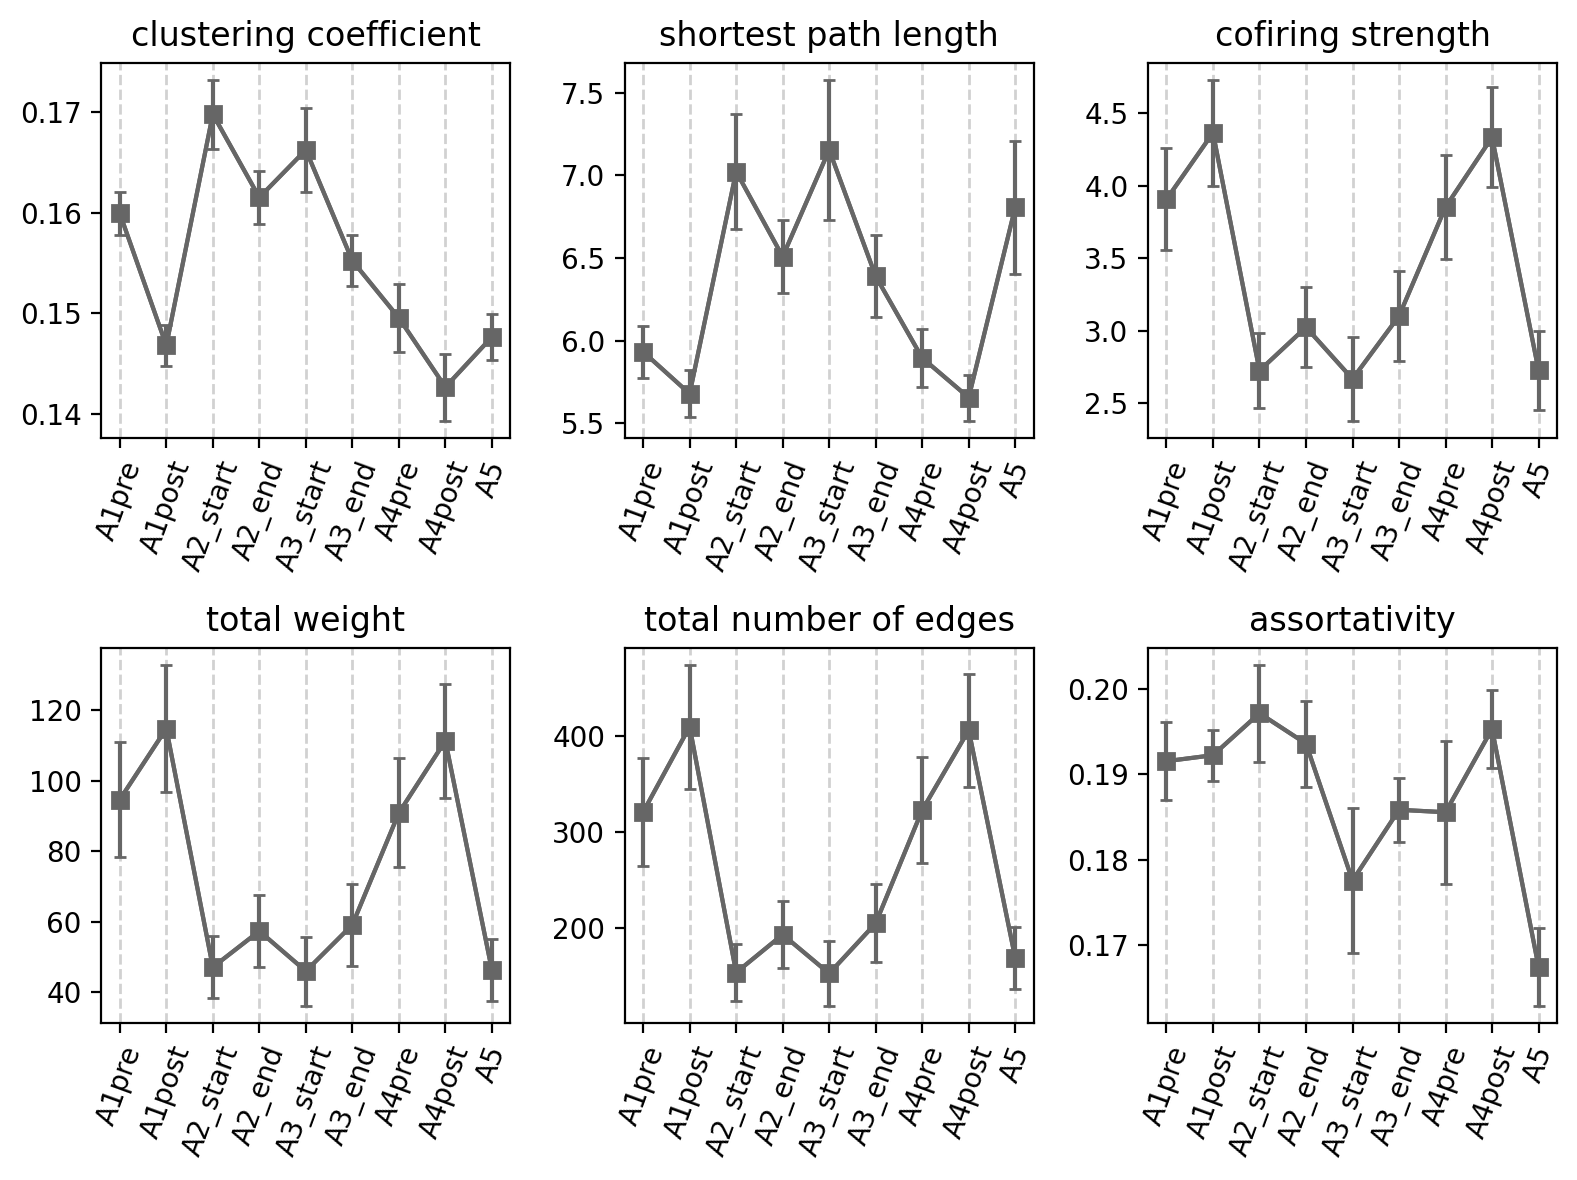

In [40]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5']
a = [1, 2, 3, 6, 7, 8, 9]
summary_df = df.iloc[a, 0:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('total weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('total number of edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

In [38]:
df.iloc[:, 24:30]

context                    A3_start                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.186367            27.522934           1.071768   
ID181106CreB               0.167706             7.739171           2.067858   
ID181106CreC               0.156823             5.755709           3.964023   
ID181106CreG               0.153494             6.489727           2.901013   
ID181106CreH               0.184428            77.063540           1.310144   
ID181106CreI               0.161634            18.826016           0.780270   
ID181106CreK               0.164022             7.714942           2.011915   
ID181106CreL               0.160224             6.661505           2.724977   
ID181106CreN               0.177870             9.141391           1.833020   
ID181106CreQ               0.183523             6.577962           3.163494   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA     6.362168                 17.69      0.139357  
ID181106CreB    26.059087                 84.92      0.146551  
ID181106CreC    93.744517                320.18      0.186098  
ID181106CreG    49.987609                173.49      0.189995  
ID181106CreH    10.395120                 29.33      0.212181  
ID181106CreI     3.486699                 11.72      0.051583  
ID181106CreK    24.538170                 81.37      0.163608  
ID181106CreL    45.151392                152.86      0.167071  
ID181106CreN    21.180803                 64.40      0.173727  
ID181106CreQ    61.700089                189.03      0.215989

In [43]:
df.iloc[:, 30:36]

context                      A3_end                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.178448             9.002108           1.580994   
ID181106CreB               0.154055             7.013385           2.276953   
ID181106CreC               0.148553             5.612840           4.290130   
ID181106CreG               0.149400             6.083029           3.209794   
ID181106CreH               0.152641             7.354388           2.020699   
ID181106CreI               0.165240            13.641736           1.145646   
ID181106CreK               0.154887             7.194039           2.255710   
ID181106CreL               0.152204             6.109437           3.226934   
ID181106CreN               0.168041             6.984890           2.428996   
ID181106CreQ               0.159468             5.730668           4.014579   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA    14.787748                 48.15      0.157499  
ID181106CreB    30.589682                107.57      0.174207  
ID181106CreC   106.307223                374.65      0.182397  
ID181106CreG    59.561140                212.91      0.181314  
ID181106CreH    24.203734                 82.95      0.174002  
ID181106CreI     7.557826                 26.77      0.096086  
ID181106CreK    30.568229                105.01      0.179973  
ID181106CreL    60.233968                209.93      0.191918  
ID181106CreN    34.036620                110.08      0.186528  
ID181106CreQ    93.111437                312.73      0.204657

In [45]:
df.iloc[:, 18:24]

context                      A2_end                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.156960             8.995001           1.528063   
ID181106CreB               0.153723             6.825532           2.422818   
ID181106CreC               0.165008             5.776160           4.046503   
ID181106CreG               0.157088             6.178632           3.095320   
ID181106CreH               0.170612            31.242910           2.012033   
ID181106CreI               0.153558            14.885862           1.071750   
ID181106CreK               0.160332             7.162020           2.247569   
ID181106CreL               0.165067             6.597855           3.011938   
ID181106CreN               0.173531             7.163336           2.411005   
ID181106CreQ               0.155834             5.858167           3.926791   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA    14.041400                 48.48      0.119717  
ID181106CreB    35.277627                121.87      0.166113  
ID181106CreC    97.059130                321.29      0.202268  
ID181106CreG    55.674777                192.26      0.193256  
ID181106CreH    24.138182                 78.30      0.191242  
ID181106CreI     6.560047                 23.10      0.064553  
ID181106CreK    30.582431                104.06      0.199451  
ID181106CreL    55.076767                182.19      0.191457  
ID181106CreN    35.830385                114.60      0.207412  
ID181106CreQ    92.359686                314.18      0.195174

In [46]:
df.iloc[:, 12:18]

context                    A2_start                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.191994            25.275975           1.179465   
ID181106CreB               0.171651             7.998943           2.129661   
ID181106CreC               0.160982             5.802420           3.857120   
ID181106CreG               0.158289             6.315079           2.918743   
ID181106CreH               0.204319            16.371133           1.478915   
ID181106CreI               0.154860            23.065800           0.778990   
ID181106CreK               0.176043             7.893508           2.000651   
ID181106CreL               0.162848             6.644640           2.742166   
ID181106CreN               0.177095             8.030401           2.178586   
ID181106CreQ               0.181537             6.477841           3.242646   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA     8.287512                 24.25      0.188260  
ID181106CreB    27.743173                 88.35      0.216361  
ID181106CreC    88.099615                292.75      0.191602  
ID181106CreG    50.411629                172.82      0.170618  
ID181106CreH    13.249141                 34.67      0.221428  
ID181106CreI     3.272909                 10.48     -0.003781  
ID181106CreK    24.416397                 77.03      0.200215  
ID181106CreL    45.704063                151.56      0.191215  
ID181106CreN    28.916127                 89.02      0.198606  
ID181106CreQ    64.915071                201.54      0.211375

In [8]:
df.iloc[:, 20:].mean()

context   feature               
A2_end    co-firing strength          2.577379
          total weight               44.660043
          total number of edges     150.033000
          assortativity               0.173064
A3_start  clustering coefficient      0.169609
                                       ...    
A4_3      shortest path length        5.424304
          co-firing strength          5.279235
          total weight              157.738270
          total number of edges     582.900000
          assortativity               0.239639
Length: 70, dtype: float64

<ipython-input-41-e839ba4b72cc>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-41-e839ba4b72cc>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-41-e839ba4b72cc>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-41-e839ba4b72cc>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-41-e839ba4b72cc>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-41-e839ba4b72cc>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


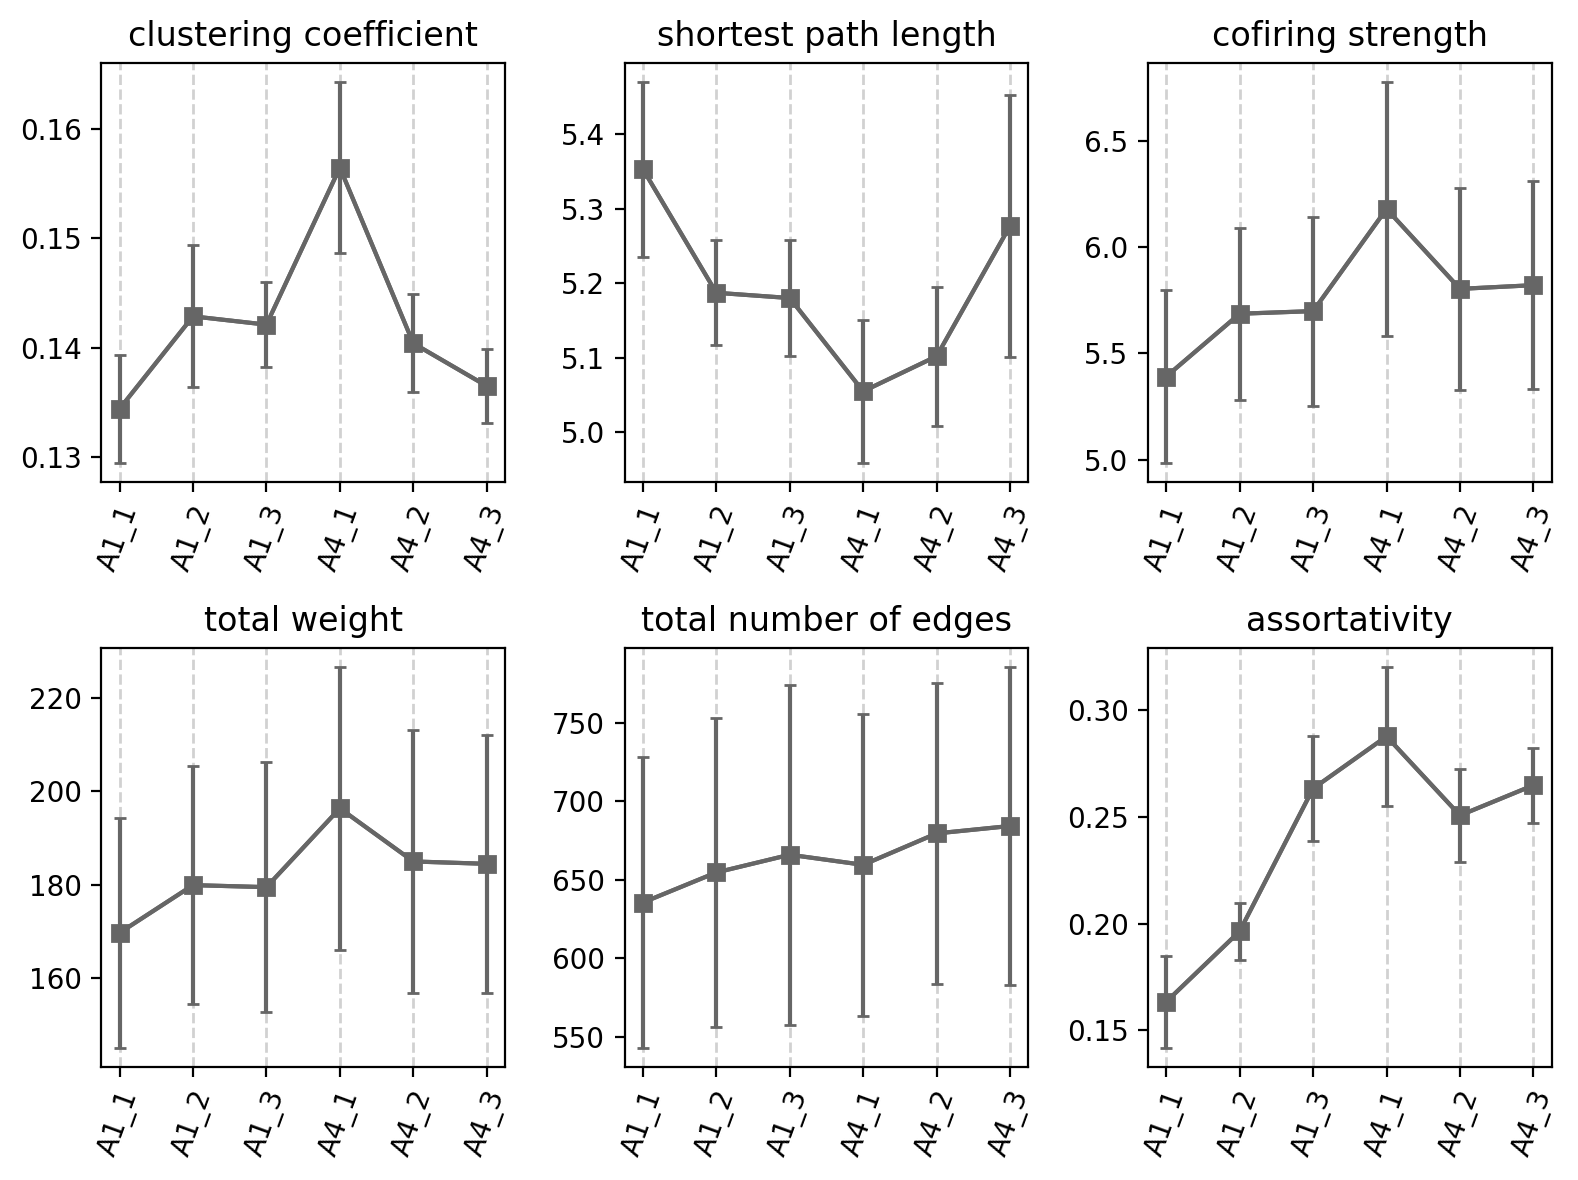

In [41]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
a = [1, 2, 3, 6, 7, 8, 9]
summary_df = df.iloc[a, 54:]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('total weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('total number of edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

<ipython-input-42-7b5747670426>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=45)
<ipython-input-42-7b5747670426>:63: UserWarning: FixedFormatter 

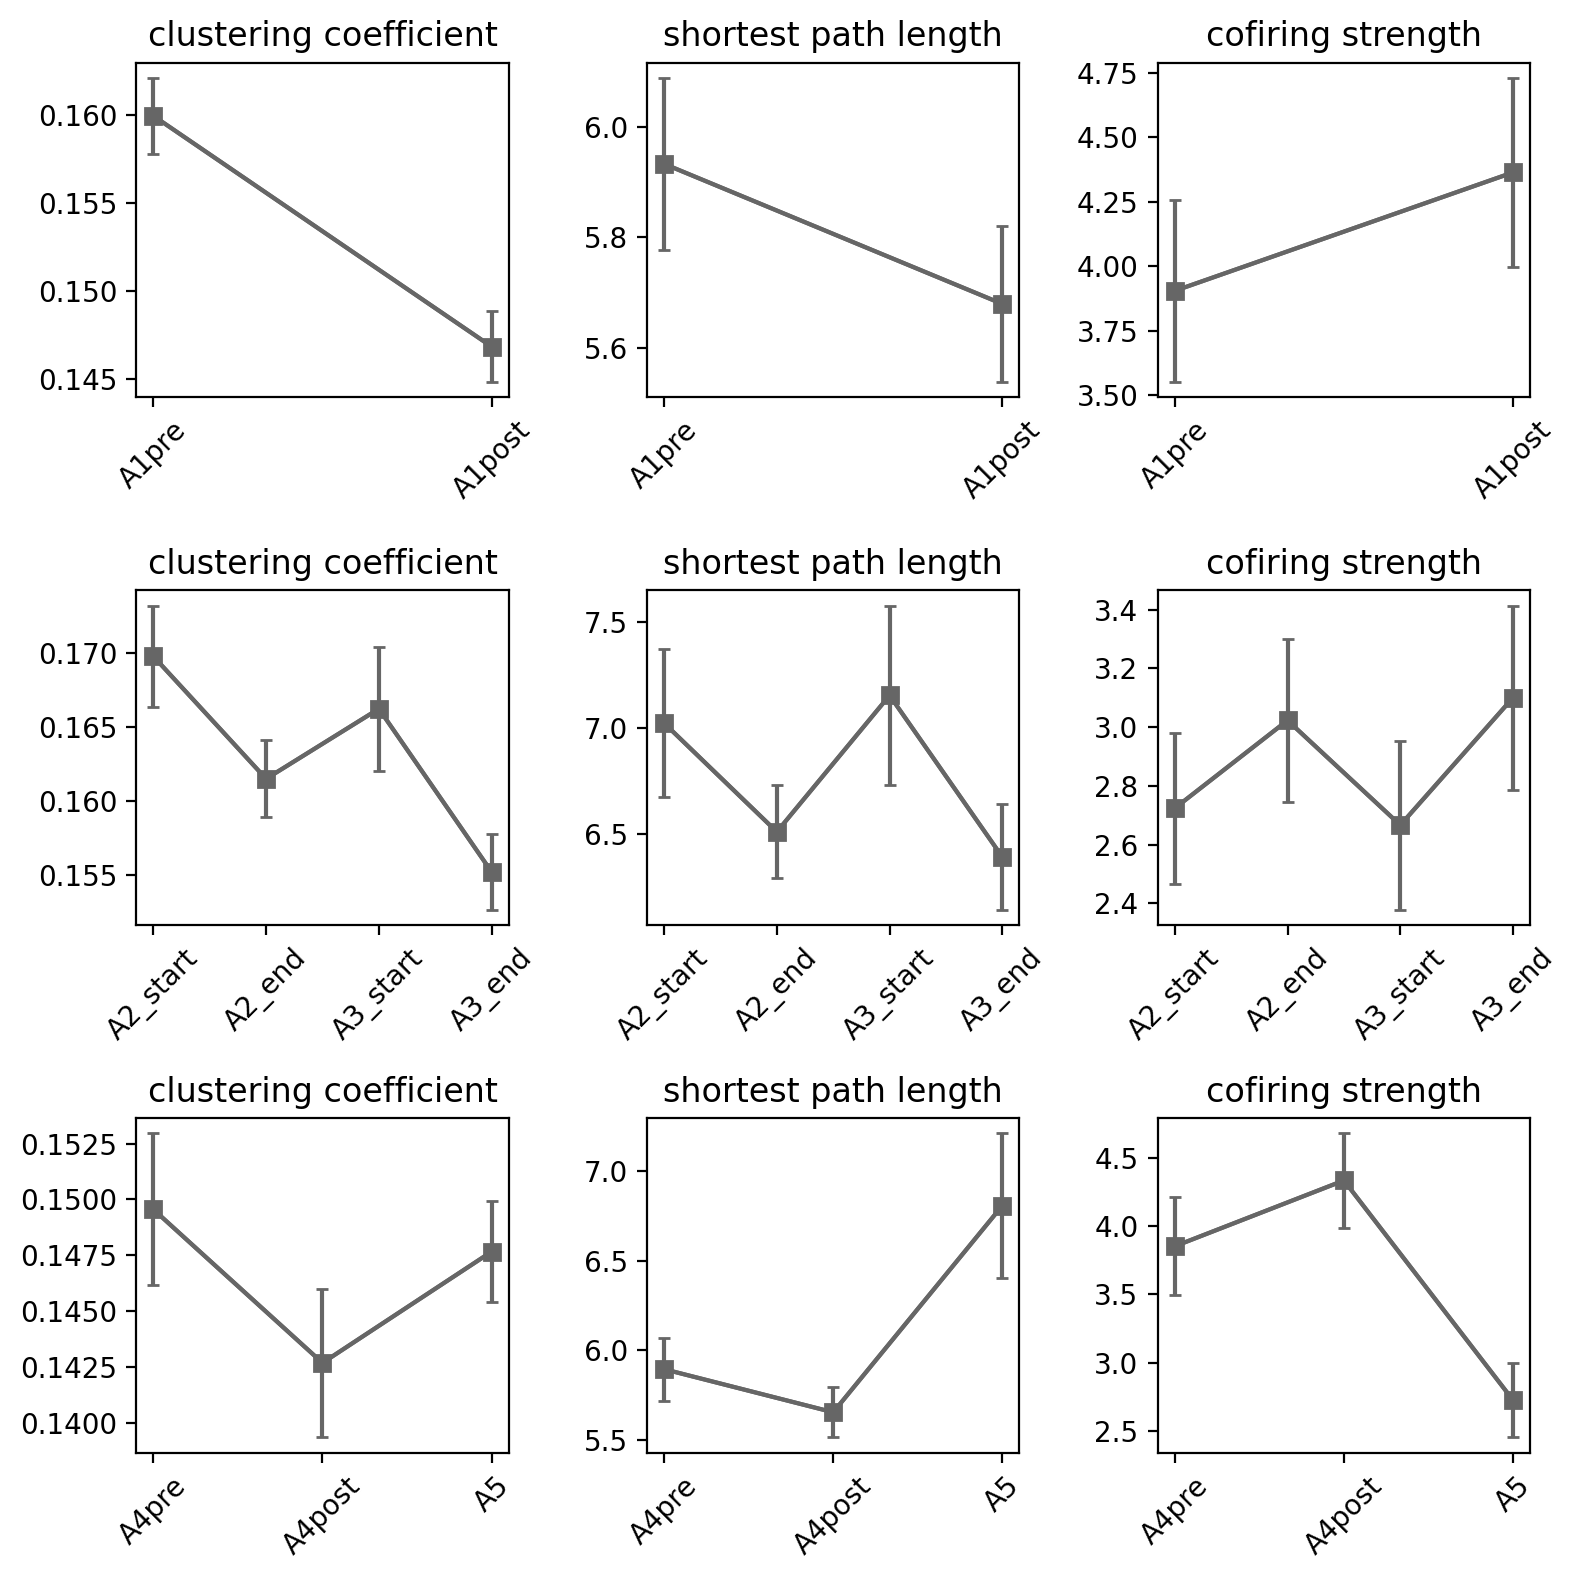

In [42]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(8, 8), tight_layout=True, dpi=200)

a = [1, 2, 3, 6, 7, 8, 9]

# A1
x = ['A1pre', 'A1post']
summary_df = df.iloc[a, 0:12]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=45)

# A2, A3

x = ['A2_start', 'A2_end', 'A3_start', 'A3_end']
summary_df = df.iloc[a, 12:36]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[1][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[1][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('clustering coefficient')
axes[1][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[1][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[1][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('shortest path length')
axes[1][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[1][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[1][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('cofiring strength')
axes[1][2].set_xticklabels(x, rotation=45)

# A4, A5

x = ['A4pre', 'A4post', 'A5']
summary_df = df.iloc[a, 36:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[2][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[2][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[2][0].set_title('clustering coefficient')
axes[2][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[2][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[2][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[2][1].set_title('shortest path length')
axes[2][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[2][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[2][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[2][2].set_title('cofiring strength')
axes[2][2].set_xticklabels(x, rotation=45)

fig.show()